<a href="https://colab.research.google.com/github/shumshersubashgautam/Yolo_Classification_Autism/blob/main/Transfer_learning_autism.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Sequential convolutional neural networks with Tensorflow and Keras & VGG architecture.**

In [1]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageChops
from IPython.display import display 

from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import backend
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.utils import plot_model 
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation 
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D, SeparableConv2D, LeakyReLU 
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

import os, shutil # Library for navigating files
from google.colab import drive # Library to mount google drives
np.random.seed(420)

In [2]:
#step 1, mount google drive (will require permission to login to your google account)
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
!cp /content/gdrive/MyDrive/autism.zip /content/

In [5]:
#step 2, specify the base directory where images are located.  You need to save your data here.
base_dir = '/content/autism/'

In [6]:

#step 3, specify the training, validation, and test directories.  
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [9]:

#step 4, specify class directory structure
train_Autistic_dir = os.path.join(train_dir, 'Autistic')
train_Non_Autistic_dir = os.path.join(train_dir, 'Non_Autistic')

test_Autistic_dir = os.path.join(test_dir, 'Autistic')
test_Non_Autistic_dir = os.path.join(test_dir, 'Non_Autistic')

In [10]:

#step 5, print total number of files in each directory, tests connection was made to files
print(len(os.listdir(train_Autistic_dir)))
print(len(os.listdir(train_Non_Autistic_dir)))
print(len(os.listdir(test_Autistic_dir)))
print(len(os.listdir(test_Non_Autistic_dir)))

1327
1327
140
140


In [11]:
# calculate class weight for each class
# important note, keras assigns classes in alphanumeric order
class_0_weight = (1 / len(os.listdir(train_Autistic_dir))) * (len(train_Autistic_dir)+len(os.listdir(train_Autistic_dir)) / 2.0)
class_1_weight = (1 / len(os.listdir(train_Non_Autistic_dir))) * (len(train_Non_Autistic_dir)+len(os.listdir(train_Non_Autistic_dir)) / 2.0)

class_weights = {0: class_0_weight, 1: class_1_weight}

print('Weight for class 0: {:.2f}'.format(class_0_weight))
print('Weight for class 1: {:.2f}'.format(class_1_weight)) 

Weight for class 0: 0.52
Weight for class 1: 0.53


Sample a random image from each directory
/content/autism/train/Autistic/1119.jpg


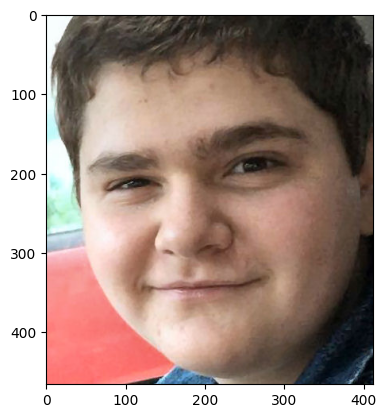

/content/autism/train/Non_Autistic/0396.jpg


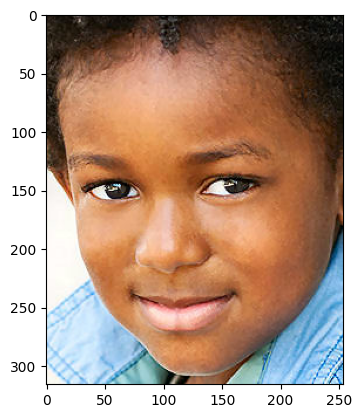

In [12]:
#step 1, create directory address for random image
Autistic_address = train_Autistic_dir+'/'+random.choice(os.listdir(train_Autistic_dir))
Non_Autistic_address = train_Non_Autistic_dir+'/'+random.choice(os.listdir(train_Non_Autistic_dir))
display_set = [Autistic_address, Non_Autistic_address]

#step 2, display random images
print("Sample a random image from each directory")
for display in display_set: 
    print(display)
    img = image.load_img(display)
    plt.figure()
    plt.imshow(img)
    plt.show() 

In [13]:
#step 1, creata augmentation image data generator
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
#    width_shift_range=0.2,
#    height_shift_range=0.2,
#    shear_range=0.2,
#    zoom_range=0.2,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
#    vertical_flip=True,
    validation_split=0.2,
    fill_mode='nearest')

#step 2, combine image data generator and flow_from_directory to setup image stream
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical',
    subset='training')

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical',
    subset='validation')


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=20,
    class_mode='categorical')

# step 3, generate batch size for training, validation, and test
training_step_size = len(train_generator)
validation_step_size = len(validation_generator)
test_step_size = len(test_generator)

Found 2124 images belonging to 2 classes.
Found 530 images belonging to 2 classes.
Found 280 images belonging to 2 classes.


In [14]:

#step 1, pull out training images and labels from generator
sample_training_images, labels = next(train_generator)

In [15]:

#step 2, define plotimages function
def plotImages(images_arr,title):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax, titl in zip( images_arr, axes, title):
        ax.set_title(titl)
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.9/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


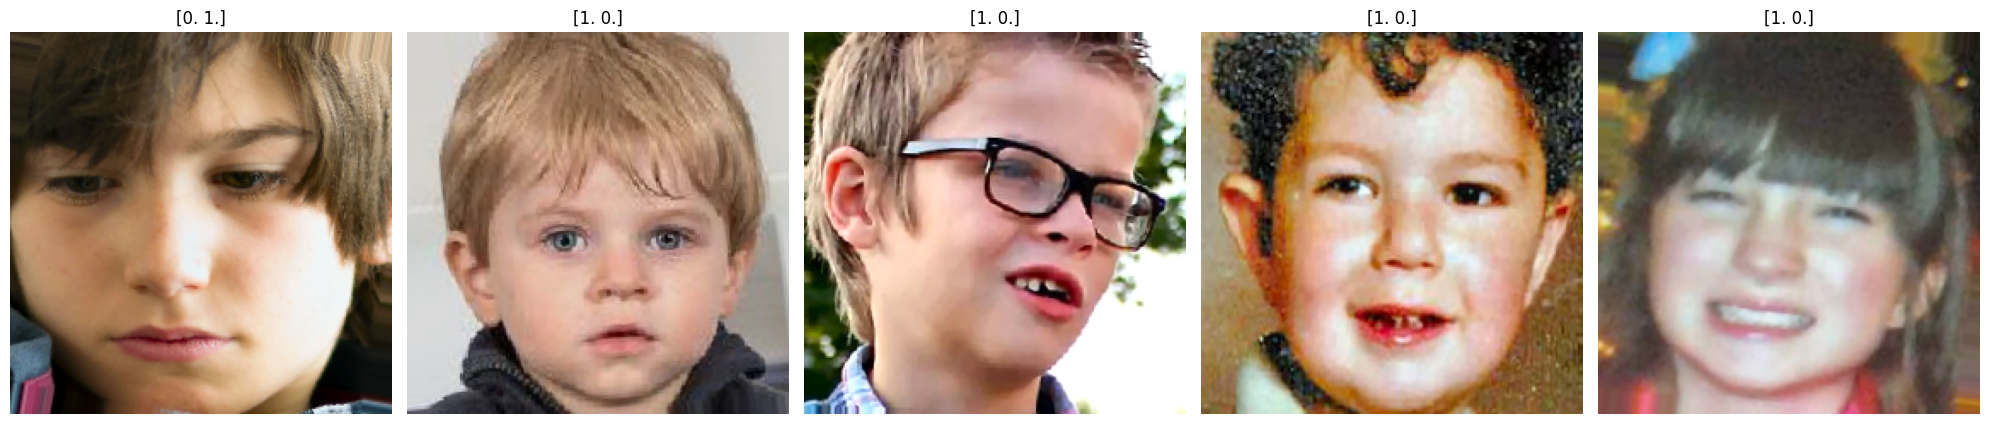

In [16]:
#step 3, plot sample of augmented images
plotImages(sample_training_images[:5], labels[:5])

Epoch 1/20
107/107 [==============================] - 79s 570ms/step - loss: 0.4234 - accuracy: 0.4976 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/20
107/107 [==============================] - 59s 547ms/step - loss: 0.3634 - accuracy: 0.4882 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 3/20
107/107 [==============================] - 55s 516ms/step - loss: 0.3633 - accuracy: 0.5005 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 4/20
107/107 [==============================] - 56s 517ms/step - loss: 0.3633 - accuracy: 0.5000 - val_loss: 0.6931 - val_accuracy: 0.5000
Epoch 5/20
107/107 [==============================] - 57s 529ms/step - loss: 0.3633 - accuracy: 0.4972 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 6/20
107/107 [==============================] - 59s 554ms/step - loss: 0.3633 - accuracy: 0.4929 - val_loss: 0.6931 - val_accuracy: 0.5000


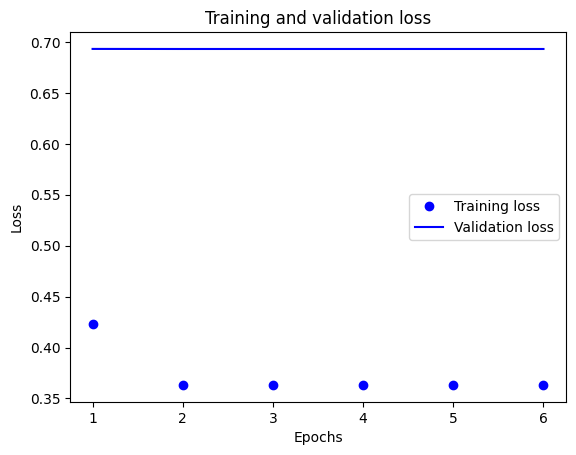

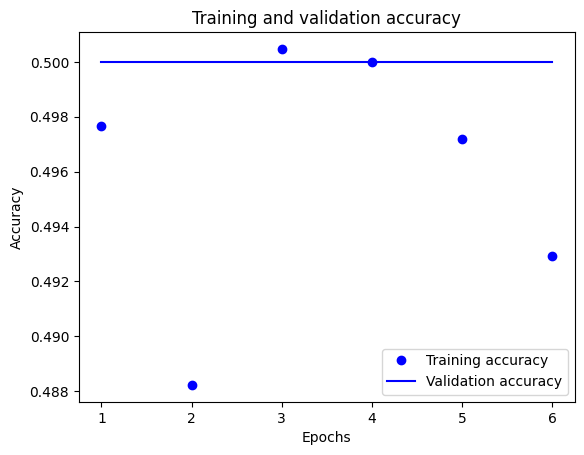

14/14 [==============================] - 1s 93ms/step - loss: 0.6932 - accuracy: 0.5000
test_acc: 0.5


In [17]:
backend.clear_session()
tf.random.set_seed(1234)
np.random.seed(1234)
vgg_model = models.Sequential()
vgg_model.add(layers.Conv2D(64, (4,4), activation = 'relu',padding='same' ,input_shape = (224, 224, 3)))
vgg_model.add(layers.Conv2D(64, (4,4), activation = 'relu',padding='same'))
vgg_model.add(layers.MaxPool2D((2,2)))
vgg_model.add(layers.Dropout(0.1))
vgg_model.add(layers.Conv2D(128, (4,4), activation = 'relu',padding='same' ))
vgg_model.add(layers.Conv2D(128, (4,4), activation = 'relu',padding='same' ))
vgg_model.add(layers.MaxPool2D((2,2)))
vgg_model.add(layers.Dropout(0.1))
vgg_model.add(layers.Conv2D(256, (4,4), activation = 'relu',padding='same' ))
vgg_model.add(layers.Conv2D(256, (4,4), activation = 'relu',padding='same' ))
vgg_model.add(layers.MaxPool2D((2,2)))
vgg_model.add(layers.Dropout(0.1))
vgg_model.add(layers.Flatten())
vgg_model.add(layers.Dense(1024, activation='relu'))
vgg_model.add(layers.Dropout(0.1))
vgg_model.add(layers.Dense(1024, activation='relu'))
vgg_model.add(layers.Dropout(0.1))
vgg_model.add(layers.Dense(2, activation='softmax'))

#step 4, compile and fit model
vgg_model.compile(optimizer = optimizers.Adam(),
    loss = 'binary_crossentropy',
    metrics = 'accuracy')

# Lr scheduler removed from model to improve performance, uncomment the code to try it.
#def scheduler(epoch, lr):
#  if epoch < 10:
#    return lr
#  else:
#    return lr * tf.math.exp(-0.1)

#defining learning rate callback for use in model.fit callbacks
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

#fit model and save training history
history = vgg_model.fit(
    train_generator,
    steps_per_epoch=training_step_size,
    epochs=20,
    class_weight=class_weights, 
    validation_data=validation_generator,
    validation_steps=validation_step_size,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)]) #lr_scheduler can be added to callbacks

#step 5, Generate graphs on training performance.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#step 6, test model on never before seen data
loss, acc = vgg_model.evaluate(test_generator, steps = test_step_size)
print('test_acc:', acc) 

In [18]:
#specify google drive location to export the trained model, include file name in h5 format
vgg_model.save('/content/vgg_model_autistic.h5')

In [19]:
# import trained model from google drive location
vgg_model = keras.models.load_model('/content/vgg_model_autistic.h5')

In [32]:
#plot confusion matrix
# Step 1, Import Required Libraries
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

# define the confusion matrix function, from the sklearn documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
     

In [33]:
#step 2, create a new, unshuffled flow_from_directory generator
confusion_test_datagen = ImageDataGenerator(rescale=1./255)

# input batch size, need variable for future calculations
batch_size_input = 20

# generate confusion generatior
confusion_test_generator = confusion_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size_input,
    class_mode='categorical',
    shuffle=False)

# create confusion step size for preditions
confusion_step_size = len(confusion_test_generator)

# create misclassified batch size to generate image with wrong predictions
misclassified_batch_size = confusion_step_size * batch_size_input

Found 280 images belonging to 2 classes.


In [34]:
#step 3, create a list of labels and predictions
test_labels = confusion_test_generator.classes
y_prob = vgg_model.predict(confusion_test_generator, steps = confusion_step_size) 
preds = y_prob.argmax(axis=-1)

14/14 [==============================] - 2s 114ms/step


In [35]:
#step 4, define class names and confusion matrix 
#Define class names
class_names = ['Autistic','Non_Autistic']

#define confusion matrix object, set true labels and preds 
cm = confusion_matrix(test_labels, preds)

Confusion matrix, without normalization
[[  0 140]
 [  0 140]]


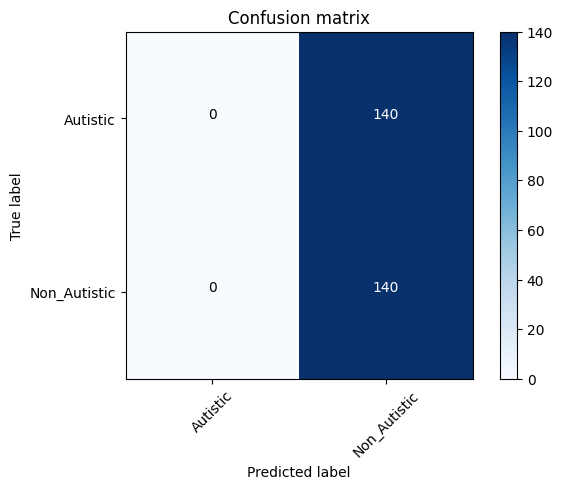

In [36]:

#step 5, plot confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix')

plt.show()

In [37]:
# step 1, create special image generator to produce sample of images for test
# resuses confusion test datagen ImageDataGenerator(w/rescaling)
misclassified_generator = confusion_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=misclassified_batch_size,
    class_mode='categorical',
    shuffle=False)

Found 280 images belonging to 2 classes.


In [38]:

# step 2, use next() to seperate pictures and labels in flow_from_directory sample
picture, true_class = next(misclassified_generator)

In [39]:
# step 3, flatten ground truth labels to a single number
truelabel=true_class.argmax(axis=1)

# flatten predictions from an array to a single number, y_prob is reused from predict() above
predlabel=y_prob.argmax(axis=1)

# step 4, select items from lists where true labels do not equal predictions
sampleimg = picture[truelabel!=predlabel]
sampletrue = truelabel[truelabel!=predlabel]
samplepred = predlabel[truelabel!=predlabel]

# show total number of misclassified images
print ('Total number of misclassified images:', sampleimg.shape[0])

#get number of images to draw
images_to_draw = sampleimg.shape[0]

Total number of misclassified images: 140


In [42]:
#step 5, define image generation function
def plot_img_results(array, true, pred, i, n=1):
    # plot the image and the target for sample i
    ncols = 4
    nrows = int(n/ncols) + 1
    fig = plt.figure( figsize=(ncols*2, nrows*2), dpi=100)
    for j in range(n):
      index = j+i
      plt.subplot(nrows,ncols, j+1)
      plt.imshow(sampleimg[index])
      plt.title('true: {} pred: {}'.format(true[index], pred[index]))
      plt.axis('off')

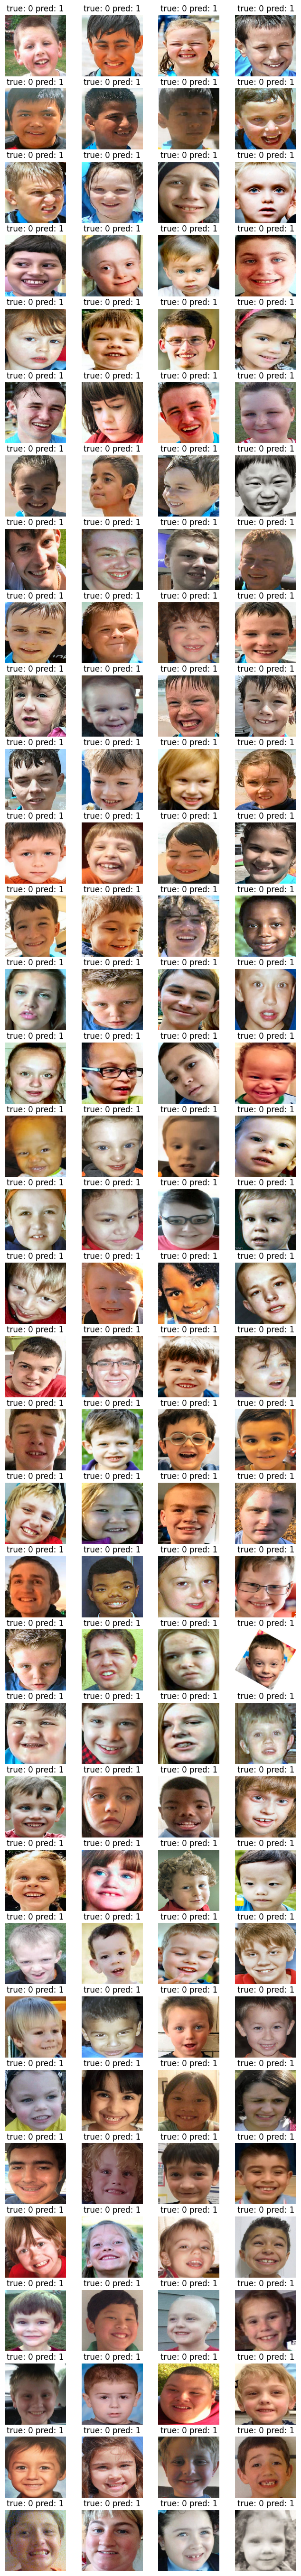

In [43]:
#use image generation function to display labels
plot_img_results(sampleimg, sampletrue, samplepred, 0, images_to_draw)

**Transfer learning with Tensorflow and Keras -XCEPTION artitecture.**

In [44]:
import tensorflow as tf
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import ImageChops
from IPython.display import display 


from tensorflow import keras
from tensorflow.keras import backend as K
from tensorflow.keras import backend
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Input, Concatenate, Dense, Dropout, Flatten, Activation, BatchNormalization 
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator 
from tensorflow.keras.applications import  Xception
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

import os, shutil 
from google.colab import drive 
np.random.seed(42)

In [45]:
#step 1, import xception model without classifier portion
backend.clear_session()
xception_base = Xception (weights = 'imagenet', include_top = False, input_shape = (224, 224, 3))

#step 2, select frozen layers
for layer in xception_base.layers[:-6]:
  layer.trainable = False
for layer in xception_base.layers:
  print(layer, layer.trainable)

83683744/83683744 [==============================] - 0s 0us/step
<keras.engine.input_layer.InputLayer object at 0x7f2234e441f0> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f2234e315e0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f23fc07b6a0> False
<keras.layers.core.activation.Activation object at 0x7f2234b24550> False
<keras.layers.convolutional.conv2d.Conv2D object at 0x7f23613f27f0> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f2234bf73d0> False
<keras.layers.core.activation.Activation object at 0x7f2234b47850> False
<keras.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x7f2234e23460> False
<keras.layers.normalization.batch_normalization.BatchNormalization object at 0x7f240992d280> False
<keras.layers.core.activation.Activation object at 0x7f2365e49e80> False
<keras.layers.convolutional.separable_conv2d.SeparableConv2D object at 0x7f2365e49d00> False
<keras.layers.no

Epoch 1/4
107/107 [==============================] - 60s 503ms/step - loss: 5.8700 - accuracy: 0.6963 - val_loss: 8.4272 - val_accuracy: 0.6170
Epoch 2/4
107/107 [==============================] - 48s 454ms/step - loss: 1.4647 - accuracy: 0.7858 - val_loss: 1.1356 - val_accuracy: 0.6792
Epoch 3/4
107/107 [==============================] - 46s 429ms/step - loss: 0.5292 - accuracy: 0.7905 - val_loss: 0.7182 - val_accuracy: 0.6358
Epoch 4/4
107/107 [==============================] - 46s 429ms/step - loss: 0.2680 - accuracy: 0.8347 - val_loss: 0.6287 - val_accuracy: 0.7132


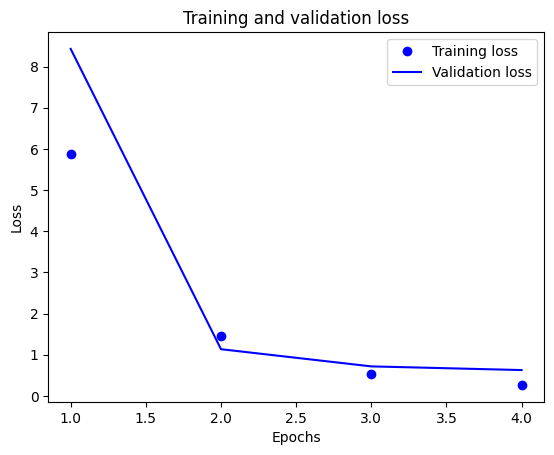

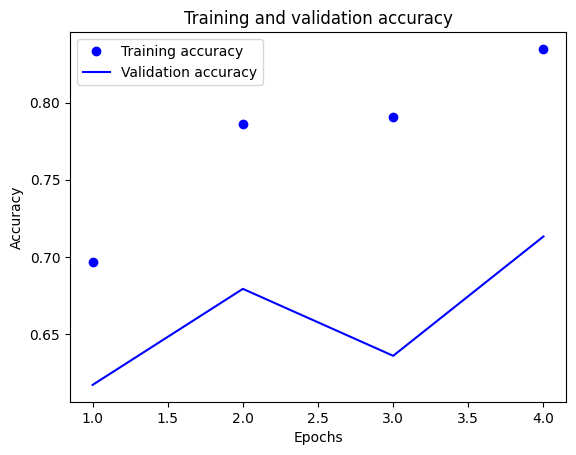

14/14 [==============================] - 1s 91ms/step - loss: 0.2964 - accuracy: 0.8750
test_acc: 0.875


In [46]:
#step 3, Create new classifier block to predict for 3 classes.
xception_train = models.Sequential()
xception_train.add(xception_base)
xception_train.add(layers.Flatten())
xception_train.add(layers.BatchNormalization())
xception_train.add(layers.Dense(1024, activation = 'relu'))
xception_train.add(layers.Dropout(0.5))
xception_train.add(layers.Dense(1024, activation = 'relu'))
xception_train.add(layers.Dropout(0.5))
xception_train.add(layers.Dense(2, activation = 'softmax'))

#step 4, compile and fit model
xception_train.compile(optimizer = optimizers.Adam(),
    loss = 'binary_crossentropy',
    metrics = 'accuracy')

# Lr scheduler removed from model to improve performance, uncomment the code to try it.
#def scheduler(epoch, lr):
#  if epoch < 10:
#    return lr
#  else:
#    return lr * tf.math.exp(-0.1)

#defining learning rate callback for use in model.fit callbacks
#lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

#fit model and save training history
history = xception_train.fit(
    train_generator,
    steps_per_epoch=training_step_size,
    epochs=4,
    class_weight=class_weights, 
    validation_data=validation_generator,
    validation_steps=validation_step_size,
    verbose = 1,
    callbacks=[EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights = True)]) #lr_scheduler can be added to callbacks

#step 5, Generate graphs on training performance.
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(history_dict['accuracy']) + 1)

plt.plot(epochs, loss_values, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss_values, 'b', label = 'Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc_values, 'bo', label = 'Training accuracy')
plt.plot(epochs, val_acc_values, 'b', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

#step 6, test model on never before seen data
loss, acc = xception_train.evaluate(test_generator, steps = test_step_size)
print('test_acc:', acc) 

In [47]:
#specify google drive location to export the trained model, include file name in h5 format
xception_train.save('/content/exception_autism.h5')

In [48]:
# import trained model from google drive location
xception_train = keras.models.load_model('/content/exception_autism.h5')

In [49]:
#plot confusion matrix
# Step 1, Import Required Libraries
%matplotlib inline
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt

# define the confusion matrix function, from the sklearn documentation
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [50]:
#step 2, create a new, unshuffled flow_from_directory generator
confusion_test_datagen = ImageDataGenerator(rescale=1./255)

# input batch size, need variable for future calculations
batch_size_input = 20

# generate confusion generatior
confusion_test_generator = confusion_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size_input,
    class_mode='categorical',
    shuffle=False)

# create confusion step size for preditions
confusion_step_size = len(confusion_test_generator)

# create misclassified batch size to generate image with wrong predictions
misclassified_batch_size = confusion_step_size * batch_size_input

Found 280 images belonging to 2 classes.


In [51]:
#step 3, create a list of labels and predictions
test_labels = confusion_test_generator.classes
y_prob = xception_train.predict(confusion_test_generator, steps = confusion_step_size) 
preds = y_prob.argmax(axis=-1)

14/14 [==============================] - 3s 120ms/step


In [52]:
#step 4, define class names and confusion matrix 
#Define class names
class_names = ['Autistic','Non_Autistic']

#define confusion matrix object, set true labels and preds 
cm = confusion_matrix(test_labels, preds)

Confusion matrix, without normalization
[[111  29]
 [  6 134]]


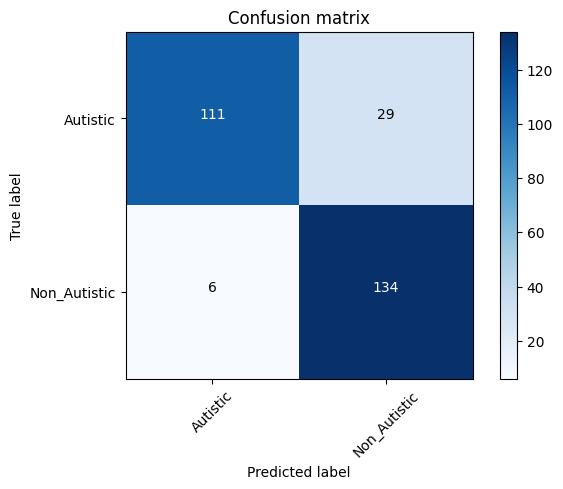

In [53]:
#step 5, plot confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=class_names,
                      title='Confusion matrix')

plt.show()
     

**Reviewing Misclassified Images**

In [54]:
# step 1, create special image generator to produce sample of images for test
# resuses confusion test datagen ImageDataGenerator(w/rescaling)
misclassified_generator = confusion_test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=misclassified_batch_size,
    class_mode='categorical',
    shuffle=False)

Found 280 images belonging to 2 classes.


In [55]:
# step 2, use next() to seperate pictures and labels in flow_from_directory sample
picture, true_class = next(misclassified_generator)

In [56]:
# step 3, flatten ground truth labels to a single number
truelabel=true_class.argmax(axis=1)

# flatten predictions from an array to a single number, y_prob is reused from predict() above
predlabel=y_prob.argmax(axis=1)

# step 4, select items from lists where true labels do not equal predictions
sampleimg = picture[truelabel!=predlabel]
sampletrue = truelabel[truelabel!=predlabel]
samplepred = predlabel[truelabel!=predlabel]

# show total number of misclassified images
print ('Total number of misclassified images:', sampleimg.shape[0])

#get number of images to draw
images_to_draw = sampleimg.shape[0]

Total number of misclassified images: 35


In [59]:
#step 5, define image generation function
def plot_img_results(array, true, pred, i, n=1):
    # plot the image and the target for sample i
    ncols = 3
    nrows = int(n/ncols) + 1
    fig = plt.figure( figsize=(ncols*2, nrows*2), dpi=100)
    for j in range(n):
      index = j+i
      plt.subplot(nrows,ncols, j+1)
      plt.imshow(sampleimg[index])
      plt.title('true: {} pred: {}'.format(true[index], pred[index]))
      plt.axis('off')

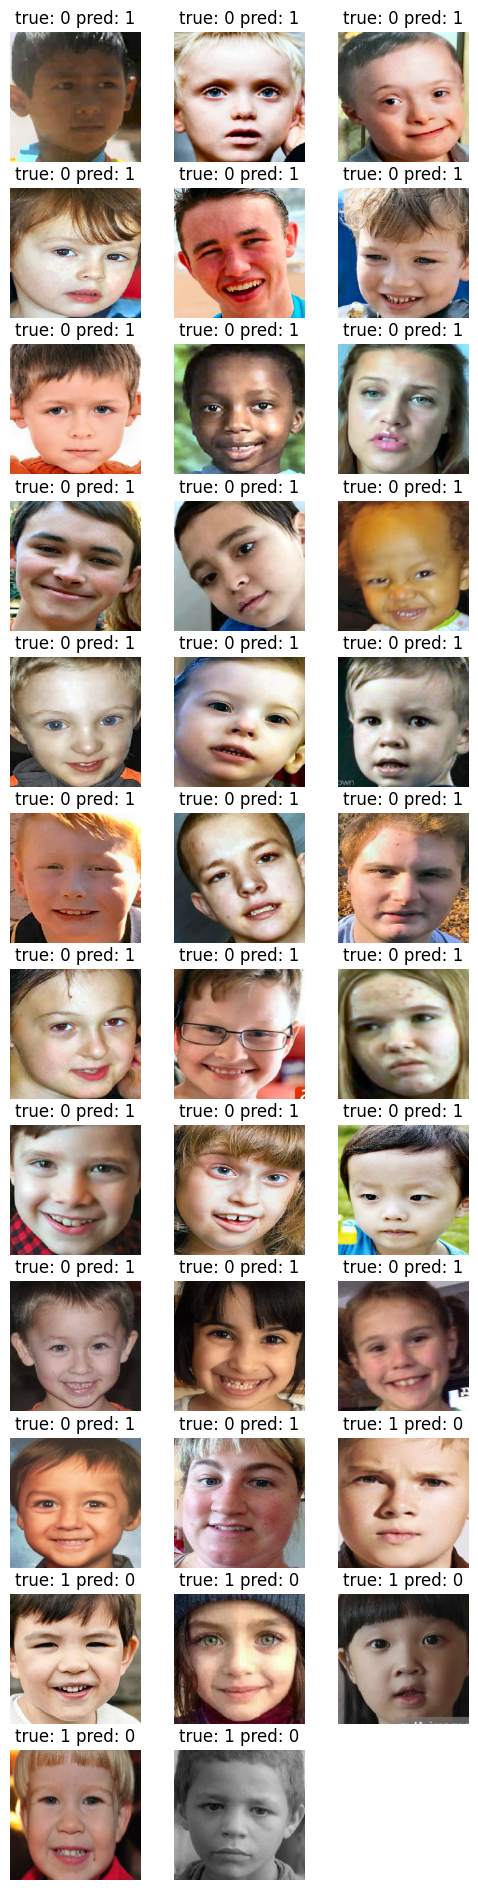

In [60]:
#use image generation function to display labels
plot_img_results(sampleimg, sampletrue, samplepred, 0, images_to_draw)

**Fastai - pretrained resnet34**

In [61]:
# from fastai.vision.all import *
# from fastai.data.all import *

In [62]:
# datapath = Path('/content/autism/')
# datapath.ls()

(#3) [Path('/content/autism/valid'),Path('/content/autism/test'),Path('/content/autism/train')]

In [63]:
# # all image names
# trainfiles = get_image_files(datapath/"train")
# validfiles = get_image_files(datapath/"valid")
# testfiles = get_image_files(datapath/"test")
# all_files = trainfiles + validfiles + testfiles

In [64]:
# # indexes of the training and testing files
# train_idxs = [i for i, fname in enumerate(all_files) if "train" in str(fname)]
# val_idxs = [i for i, fname in enumerate(all_files) if "valid" in str(fname)]
# test_idxs = [i for i, fname in enumerate(all_files) if "test" in str(fname)]

In [65]:
# # how to get image label: autistic, non-autistic
# def label_func(fname):
#     return re.match(r'^(.*)/(.*)$', fname.parent.as_posix()).groups()[1]

In [66]:
# dblock = DataBlock(blocks    = (ImageBlock, CategoryBlock),
#                    get_y     = label_func,
#                    splitter=lambda x: [train_idxs, test_idxs])